# <center> Google App store analysis </center>

## Google App Store Data Analysis
Project Title : Google App Store Data Analysis

Technologies : Data Science

Domain : Technology

Project Difficulties level : Intermediate

## Author : Akshaya L

In [334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

## Basic analysis
First let's do some basic analysis to discover what our data looks like

In [335]:
df = pd.read_csv('./googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


We can already notice that we have a lot of categorical columns: Category, Installs, Type, Content Rating, Genres, Current Ver and Android Ver.

We can also notice the App column that contains the App name, meaning that all its values will most likely be unique.

In [336]:
df.duplicated().sum()

483

We see that we have duplicated rows, let's drop them to not impact our analysis

In [337]:
df.shape

(10841, 13)

In [338]:
df.drop_duplicates(inplace=True)
df.shape

(10358, 13)

In [339]:
df.describe()

,Rating
count,8893.000000
mean,4.189542
std,0.545452
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


Rating has a max of 19, while the play store rates from 1 to 5. We have invalid data to remove here.

In [340]:
df.sort_values(by=['Rating'], ascending=False).head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN
5139,Chenoweth AH,MEDICAL,5.0,1,27M,100+,Free,0,Everyone,Medical,"April 3, 2017",300000.0.78,4.0.3 and up
6851,BV Mobile Apps,PRODUCTIVITY,5.0,3,4.8M,100+,Free,0,Everyone,Productivity,"June 5, 2018",2.0,4.2 and up
6807,Jabbla BT,TOOLS,5.0,3,55k,100+,Free,0,Everyone,Tools,"October 6, 2014",1.0,4.2 and up
6816,BU Study,FAMILY,5.0,7,5.6M,10+,Free,0,Everyone,Education,"December 7, 2017",1.0,4.0.3 and up


In [341]:
df.drop(10472, inplace=True);

In [342]:
df.shape

(10357, 13)

In [343]:
df.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

We notice here that even if some columns like Reviews contains numeric values, they are encoded as objects.

In [344]:
df.isnull().sum()

App                  0
Category             0
Rating            1465
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       0
Genres               0
Last Updated         0
Current Ver          8
Android Ver          2
dtype: int64

Our data is pretty clean in term of NAN values, except for the Rating column which has 14% missing values

## Cleaning up the data from any NAN values

In [345]:
# The columns 'Type','Content Rating', 'Current Ver' and 'Android Ver' have so few missing numbers
# that we can delete these rows
df_no_nan = df.dropna(axis=0, subset=['Type','Content Rating', 'Current Ver', 'Android Ver'])

(0, 7)

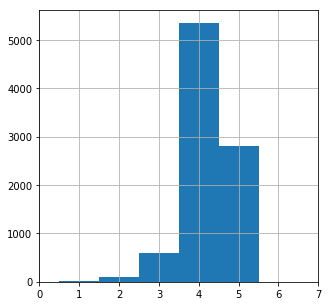

In [346]:
# In terms of Rating, it all depends on what information we want to extract from our data. Let's see its distribution
plt.figure(figsize=(5,5))
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
df['Rating'].hist(bins = bins);
plt.xlim(0,7)

We have a left queued normal distribution with a maximum around 4.

We can already say that our data shows that people who DO rate are mostly the one that are the most satisfied with the apps. Thus the missing values might indicate an app that is not good enough for people to take the time to rate it. In this condition we cannot afford to take the decision to replace a missing value by the mean (which is 4.19) since it would probably not represent the reality.

We could then choose to either remove the missing value rows or give them a value like 0 which is outside of the rating range but would probably be more realistic of the type of grade we would get if the value was existing.

In [347]:
fill_nan = lambda col: col.fillna(0)
df_0_Rating = df_no_nan.apply(fill_nan, axis=0)

df_no_nan = df_no_nan.dropna(axis=0, subset=['Rating'])

## Data analysis

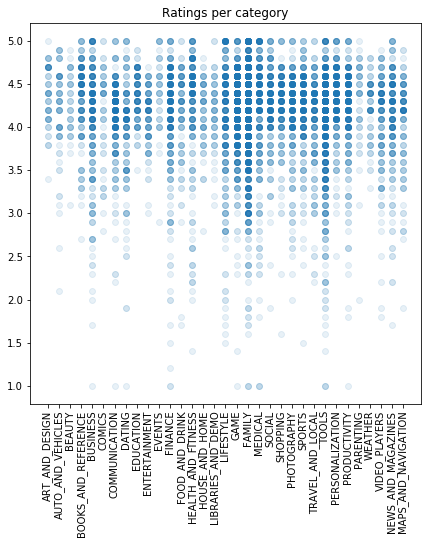

In [348]:
plt.figure(figsize=(7,7))
plt.scatter(df_no_nan['Category'], df_no_nan['Rating'], alpha =.1);
plt.title('Ratings per category');
plt.xticks(rotation = 90);

We see here that the rating is mostly concentrated between 4 and 4.5, except for categories like family which have a larger range because they have more values.

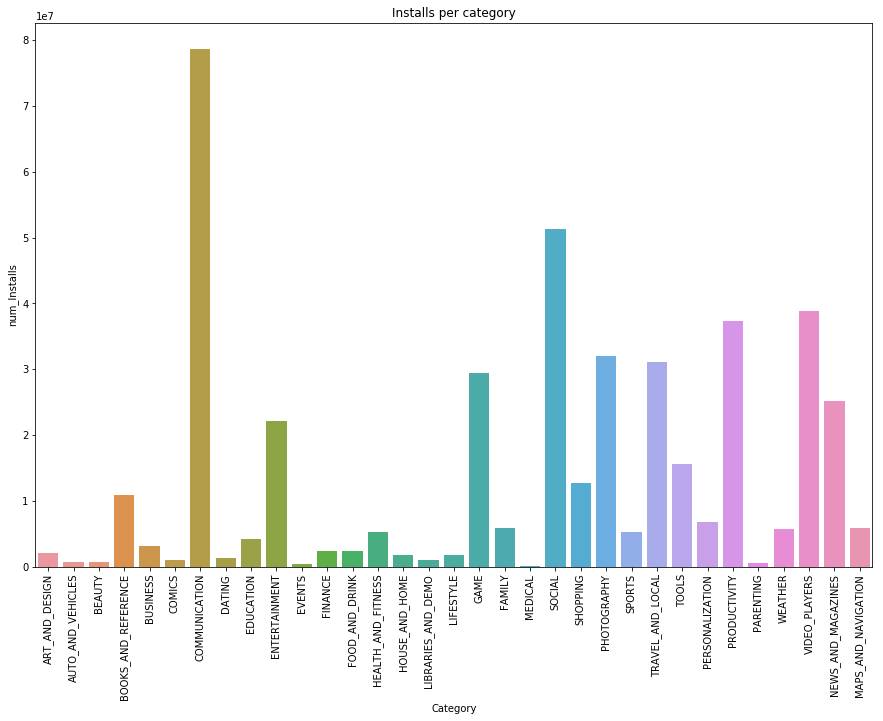

In [349]:
df_no_nan['num_Installs'] = df_no_nan['Installs'].apply({'10,000+':10000, '500,000+':500000, '5,000,000+':5000000,'50,000,000+':50000000, '100,000+':100000, '50,000+':50000, '1,000,000+':1000000, '10,000,000+':10000000, '5,000+':5000, '100,000,000+':100000000, '1,000,000,000+':1000000000, '1,000+':1000, '500,000,000+':500000000, '50+':50, '100+':100, '500+':500, '10+':10, '1+':1, '5+':5, '0+':0 }.get)

sns.barplot(x='Category', y='num_Installs', data=df_no_nan, ci = None);
plt.title('Installs per category');
plt.xticks(rotation = 90);

We can see here that the communication apps are much more installed than any other categories

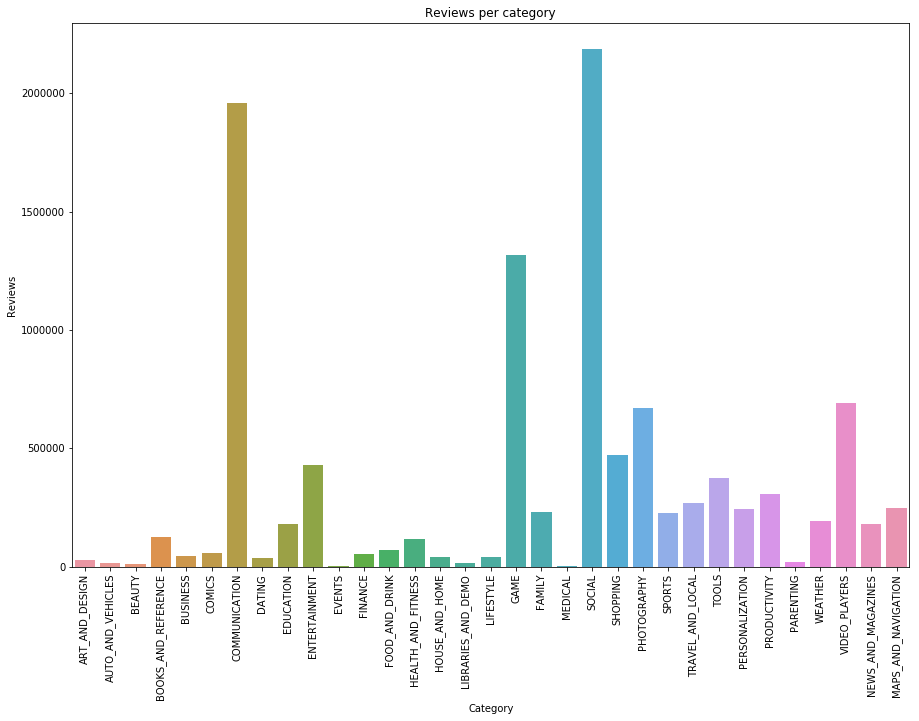

In [350]:
df_no_nan['Reviews'] = df_no_nan['Reviews'].astype('float64')

sns.barplot(x='Category', y='Reviews', data=df_no_nan, ci = None);
plt.title('Reviews per category');
plt.xticks(rotation = 90);

The social apps are the most reviewed, closely followed by the communicaion apps.

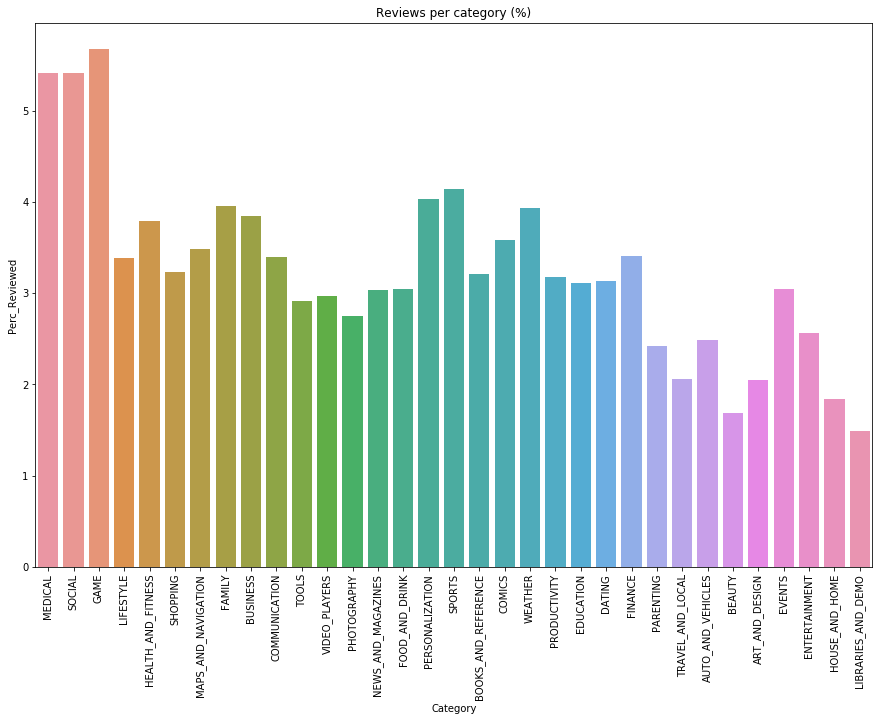

In [351]:
df_no_nan['Perc_Reviewed'] = df_no_nan['Reviews']/df_no_nan['num_Installs']*100;
sns.barplot(x='Category', y='Perc_Reviewed', data=df_no_nan.sort_values(by='Perc_Reviewed', ascending=False), ci = None);
plt.title('Reviews per category (%)');
plt.xticks(rotation = 90);

The number of reviews per category is biaised by the number of installations per category. If a category is more installed, it is expected to be more reviewed. To remove this biais we plotted the percentage of reviewed and now we see that the games are much likely to be reviewed than any other apps. Though they are closely followed by the social and medical apps.

In [352]:
df_number_per_category = df_no_nan.groupby('Category')['App'].nunique()
df_number_per_category = df_number_per_category.to_frame()
df_number_per_category['Category'] = df_number_per_category.index
df_number_per_category.columns=['Count', 'Category']
df_number_per_category['Percentage'] = df_number_per_category['Count']/df_number_per_category.shape[0]
df_number_per_category.sort_values(by='Percentage', ascending=False).head(10)

,Count,Category,Percentage
Category,,,
FAMILY,1683,FAMILY,51.000000
GAME,913,GAME,27.666667
TOOLS,719,TOOLS,21.787879
FINANCE,302,FINANCE,9.151515
LIFESTYLE,301,LIFESTYLE,9.121212
PRODUCTIVITY,301,PRODUCTIVITY,9.121212
PERSONALIZATION,296,PERSONALIZATION,8.969697
MEDICAL,291,MEDICAL,8.818182
BUSINESS,263,BUSINESS,7.969697


Here we can see that 51% of the apps in the app store are classified as family while 27% are games and 21% are tools. Let's not forget that a lot of apps are classified in several categoris and so the total percentage WILL BE higher than 100%

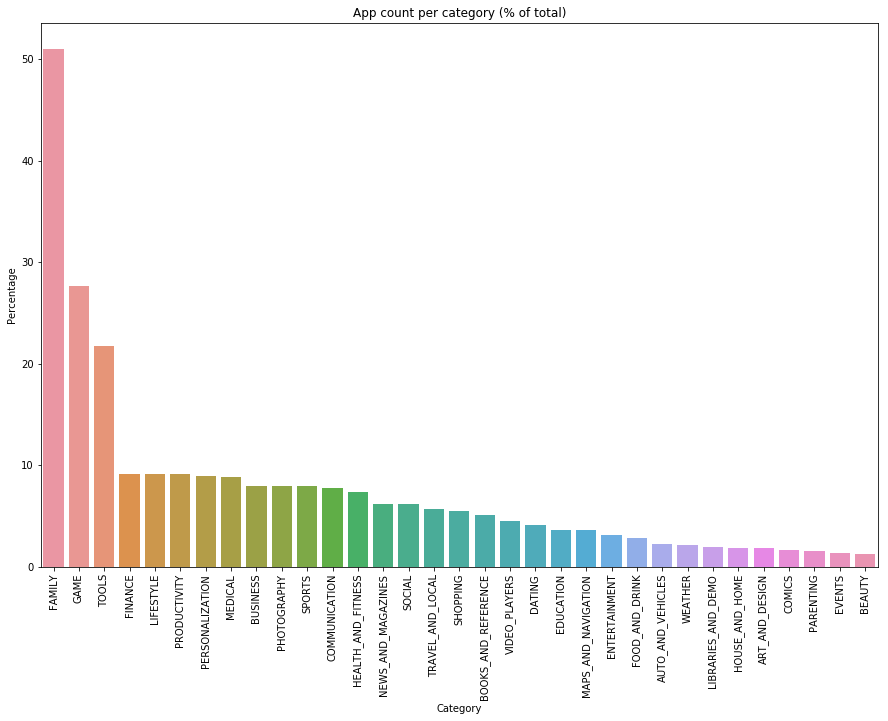

In [353]:
sns.barplot(x='Category', y='Percentage', data=df_number_per_category.sort_values(by='Percentage', ascending=False), ci = None);
plt.title('App count per category (% of total)');
plt.xticks(rotation = 90);

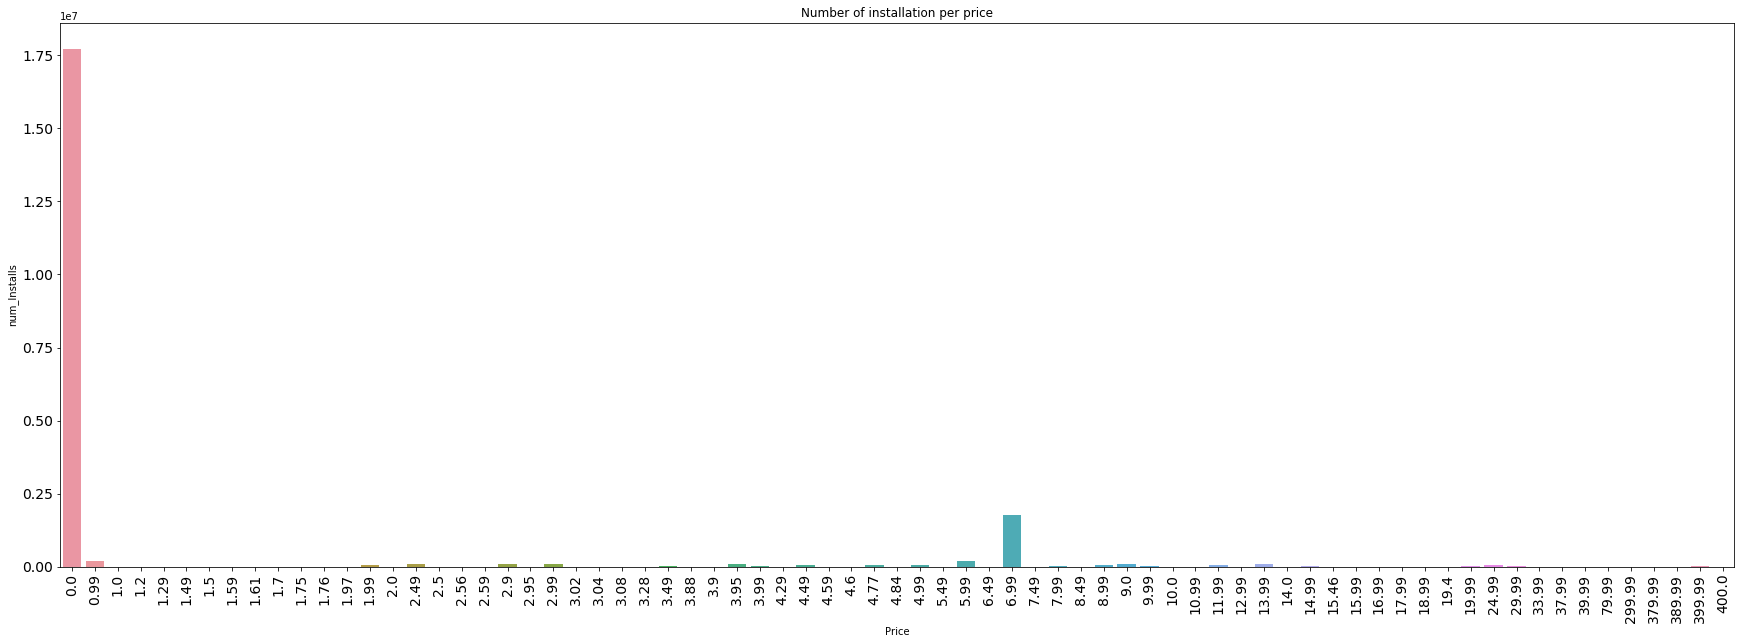

In [354]:
df_no_nan['Price'] = df_no_nan['Price'].apply(lambda x : x.replace('$', ''))
df_no_nan['Price'] = df_no_nan['Price'].astype('float64')
plt.figure(figsize=(30, 10))
plt.title('Number of installation per price');
plt.xticks(rotation = 90, fontsize=14);
plt.yticks(fontsize=14);
sns.barplot(x='Price', y='num_Installs', data=df_no_nan, ci = None);

Here we can clearly see that the free apps are by far the most installed. After that, the apps paid 6.99$ are the most installed

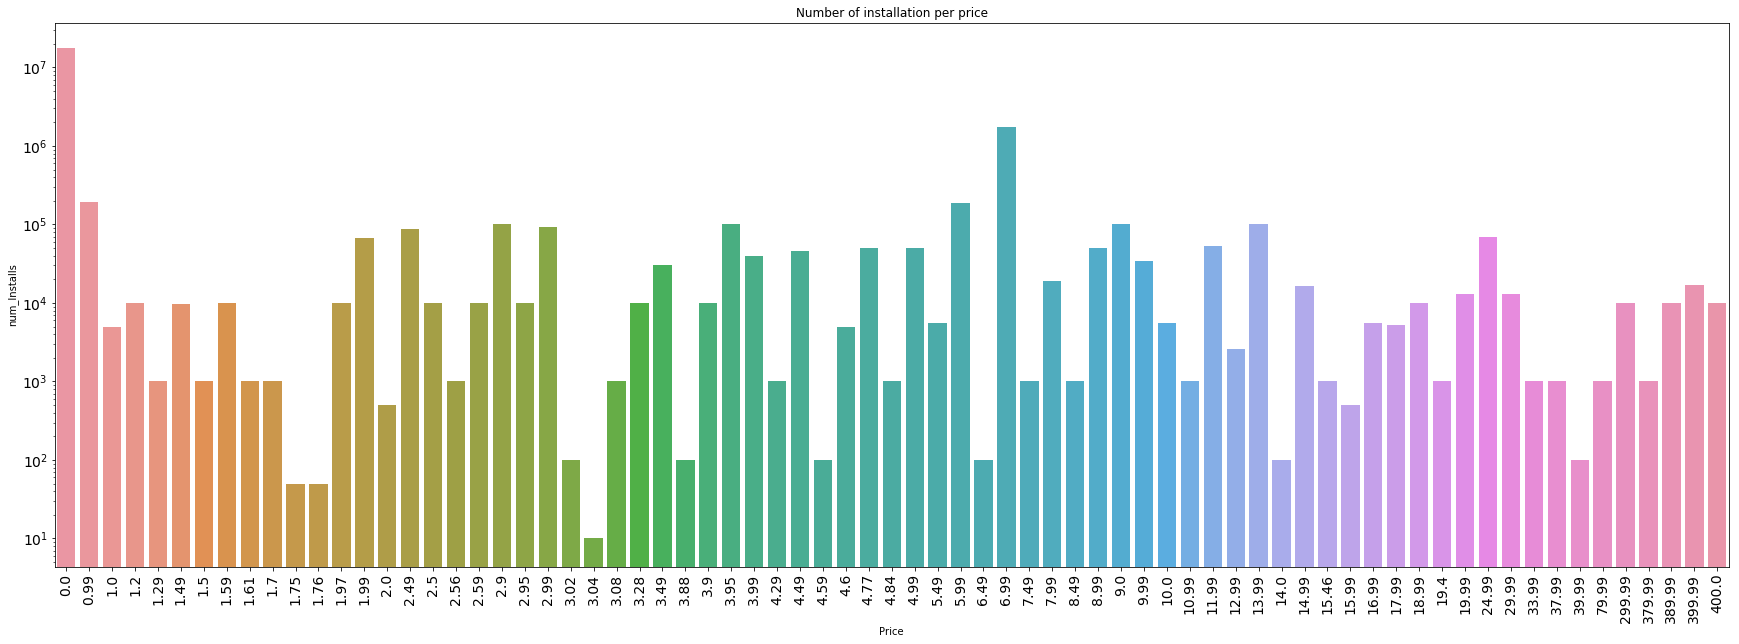

In [355]:
plt.figure(figsize=(30, 10))
plt.title('Number of installation per price');
plt.xticks(rotation = 90, fontsize=14);
plt.yticks(fontsize=14);
plt.yscale('log')
sns.barplot(x='Price', y='num_Installs', data=df_no_nan, ci = None);

In [356]:
df_no_nan['cumul_Installs_per_price'] = df_no_nan.groupby(['Price'])['num_Installs'].apply(lambda x: x.cumsum())
df_no_nan_cumsum = df_no_nan.groupby(['Price']).agg({'cumul_Installs_per_price': 'sum'})
df_no_nan_cumsum['percentage']=df_no_nan_cumsum['cumul_Installs_per_price']/df_no_nan_cumsum['cumul_Installs_per_price'].sum()*100
df_no_nan_cumsum.sort_values(by='percentage', ascending = False).head()

,cumul_Installs_per_price,percentage
Price,,
0.00,835889058796914,99.999711
0.99,1407569111,0.000168
2.99,481841680,0.000058
6.99,185293300,0.000022
4.99,102784560,0.000012


More than 99.99% of the installed apps are free!

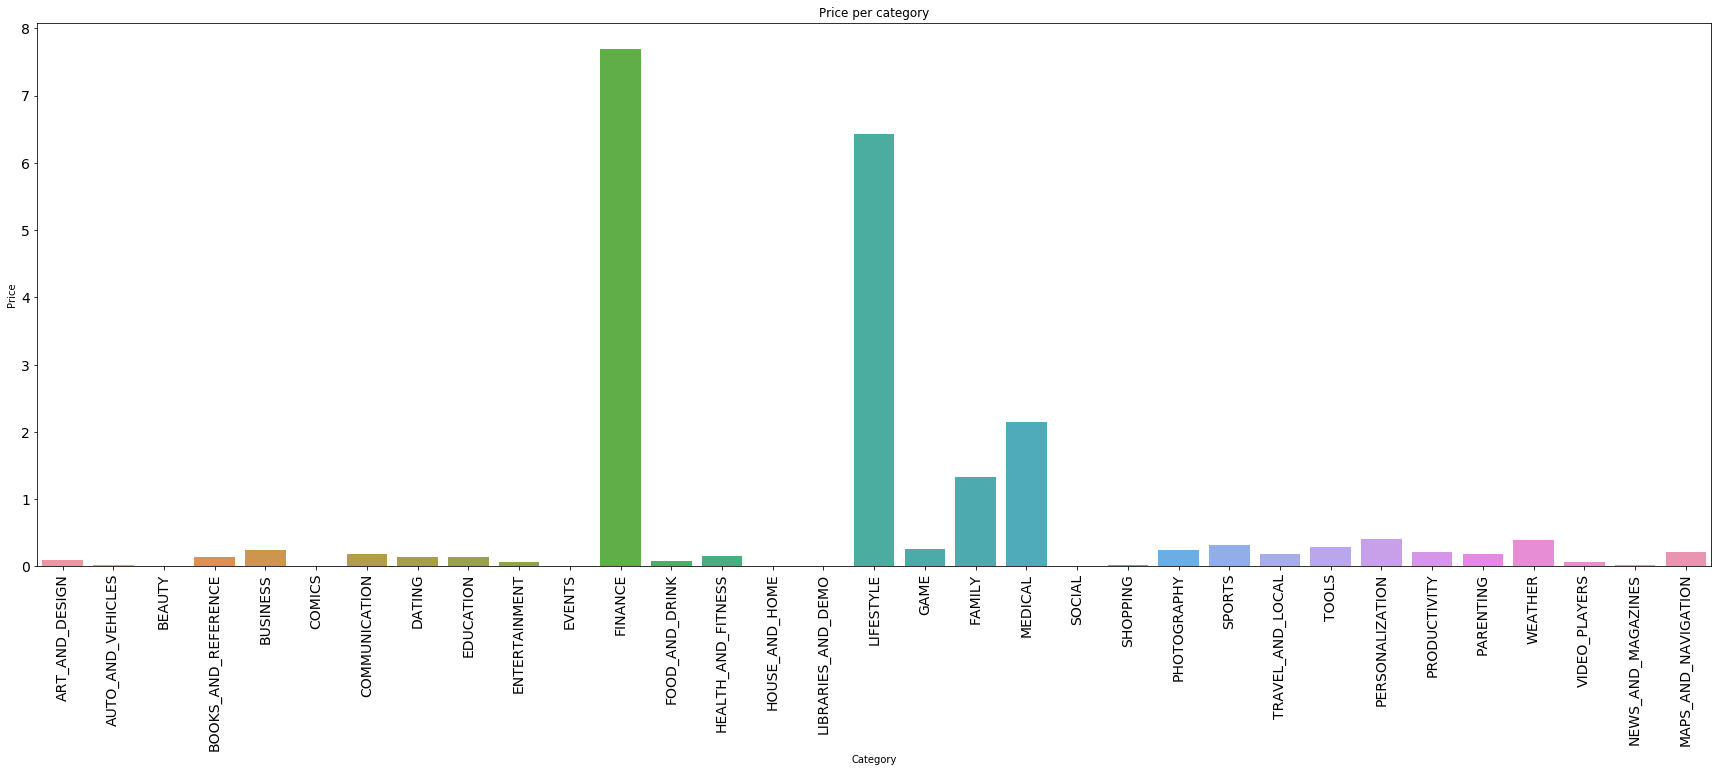

In [357]:
plt.figure(figsize=(30, 10))
plt.title('Price per category');
plt.xticks(rotation = 90, fontsize=14);
plt.yticks(fontsize=14);
sns.barplot(x='Category', y='Price', data=df_no_nan, ci = None);

The price of the apps clearly depends on the category: the financial apps are sold at a much higher price than most of the other ones.

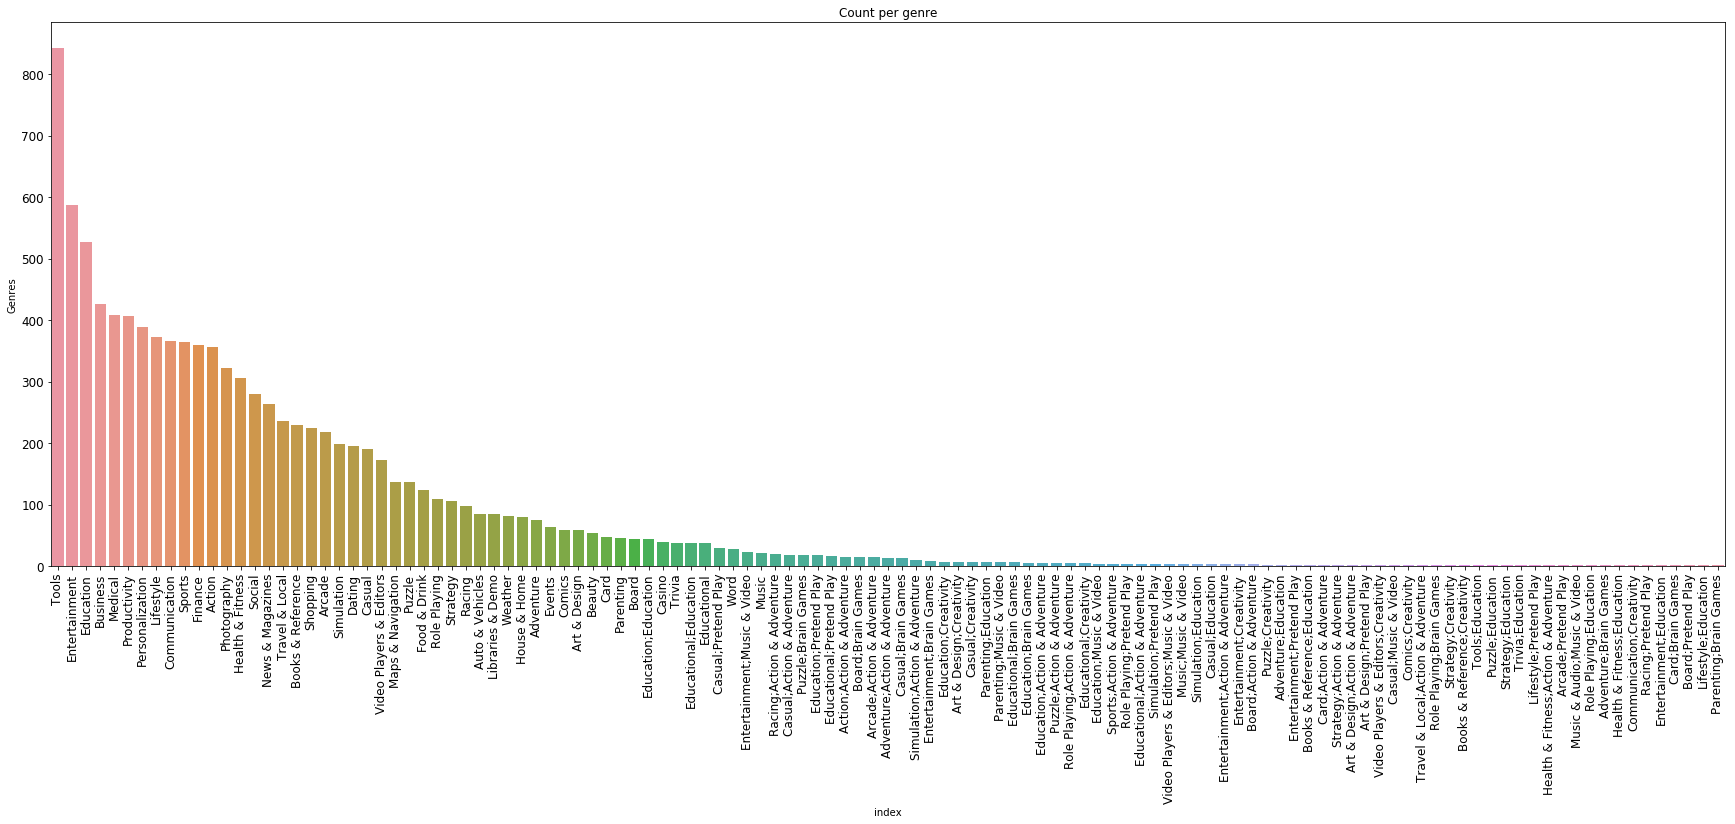

In [358]:
plt.figure(figsize=(30, 10))
plt.title('Count per genre');
plt.xticks(rotation = 90, fontsize=12);
plt.yticks(fontsize=12)
sns.barplot(y=df['Genres'].value_counts().reset_index()['Genres'], x=df['Genres'].value_counts().reset_index()[:]['index']);

The apps with a genre tools, entertainment and education represent the most part of the play store.

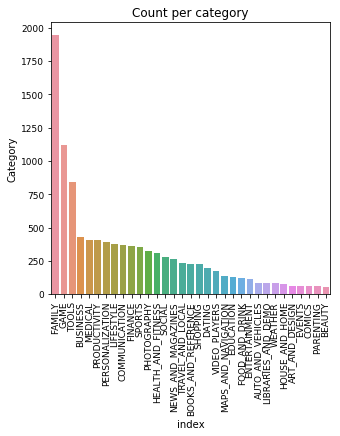

In [359]:
plt.figure(figsize=(5, 5))
plt.title('Count per category');
plt.xticks(rotation = 90, fontsize=9);
plt.yticks(fontsize=9);
sns.barplot(y=df['Category'].value_counts().reset_index()['Category'], x=df['Category'].value_counts().reset_index()['index']);

The categories the most represented is the app store are family, game and tools

C:\Users\Soizic\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


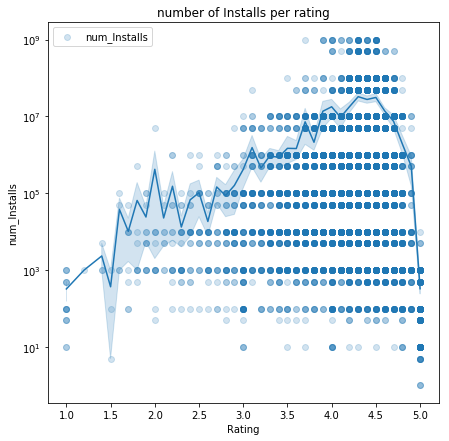

In [360]:
plt.figure(figsize=(7,7))
plt.title('number of Installs per rating')
plt.scatter( x=df_no_nan['Rating'], y=df_no_nan['num_Installs'], alpha = 0.2)
sns.lineplot(x="Rating", y="num_Installs", data=df_no_nan) 
plt.yscale('log')

We can see here that the number of installs and the rating are proportional until a rating of approximately 4.5, After that the number of installs drops considerably, probably meaning that the apps with a rating greater than 4.5 are mostly installed by friends and family

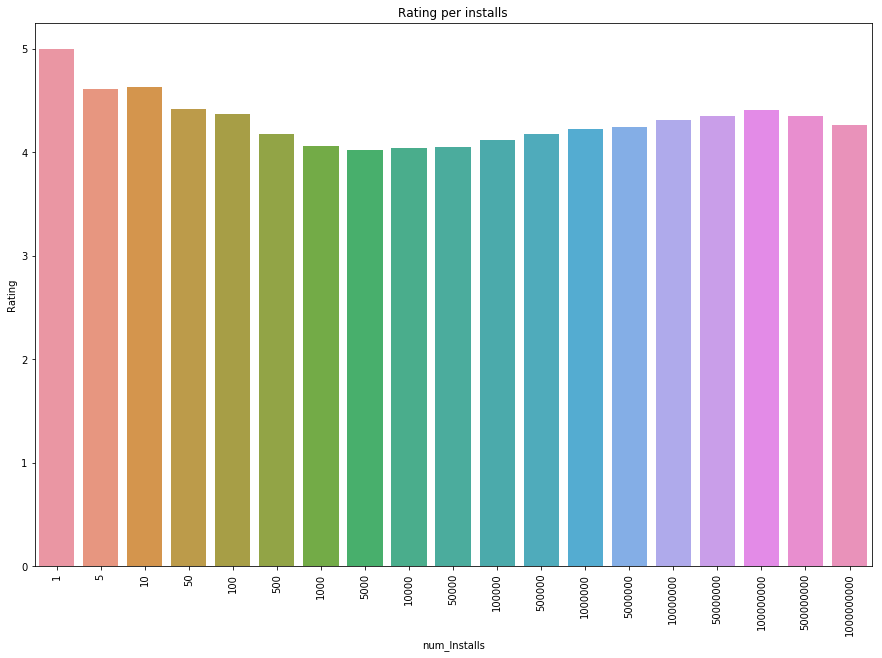

In [361]:
sns.barplot(x='num_Installs', y='Rating', data=df_no_nan, ci = None);
plt.title('Rating per installs');
plt.xticks(rotation = 90);

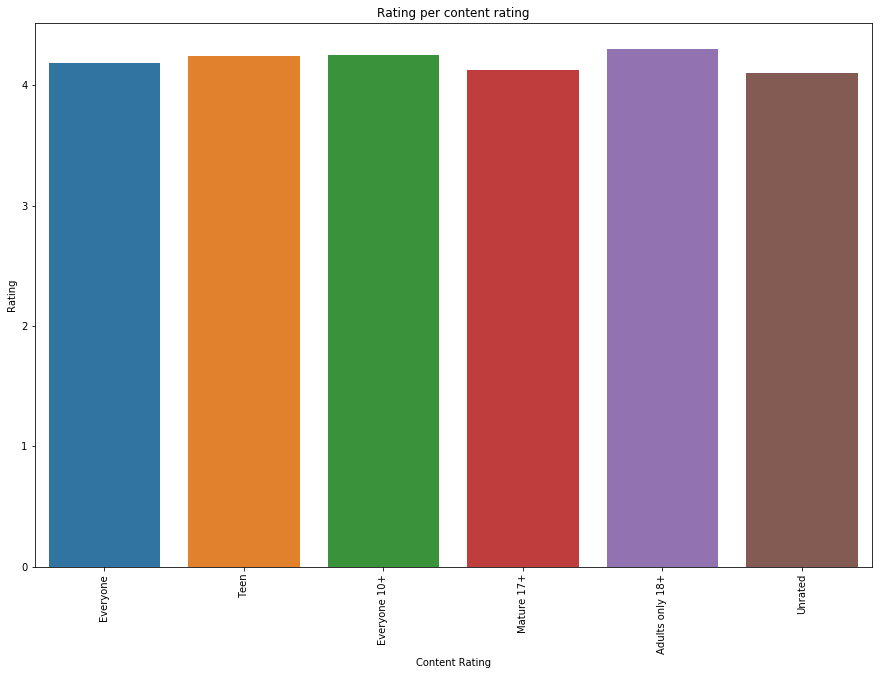

In [362]:
sns.barplot(x='Content Rating', y='Rating', data=df_no_nan, ci = None);
plt.title('Rating per content rating');
plt.xticks(rotation = 90);

The content rating of an app does not impact much its rating in the play store

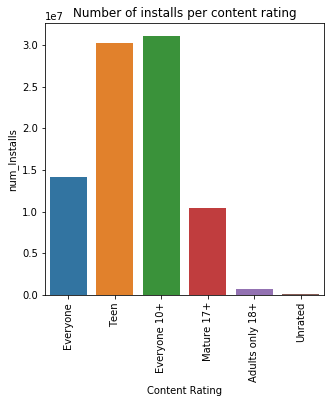

In [363]:
plt.figure(figsize=(5,5))
plt.title('Number of installs per content rating')
sns.barplot(y="num_Installs", x="Content Rating", data=df_no_nan, ci=None)
plt.xticks(rotation = 90);

Though the apps targetting teenagers are much more installed than the other ones.

## Modeling

C:\Users\Soizic\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Rating VS Installs')

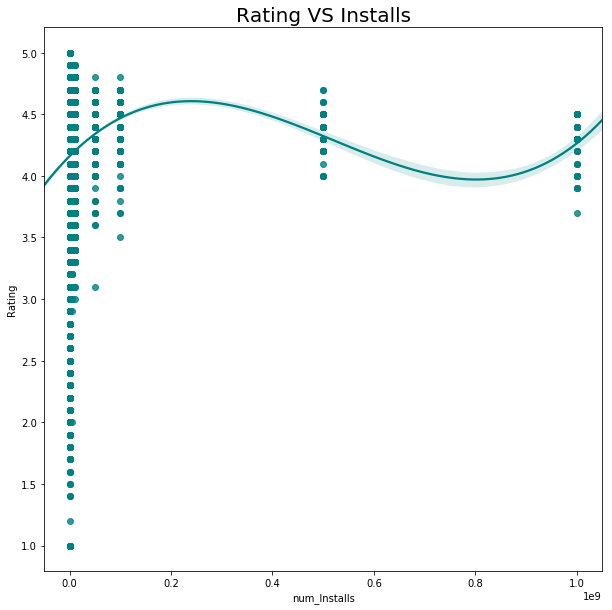

In [364]:
plt.figure(figsize = (10,10))
sns.regplot(x="num_Installs", y="Rating", color = 'teal',data=df_no_nan, order=3);
plt.title('Rating VS Installs',size = 20)

C:\Users\Soizic\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Soizic\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


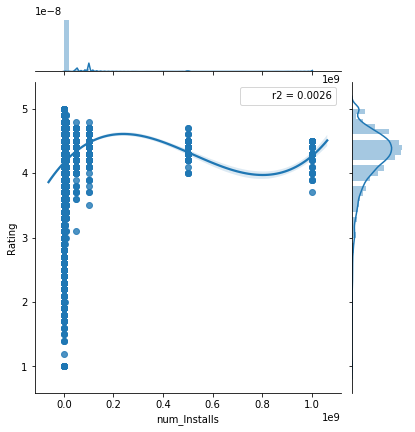

In [365]:

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(df_no_nan['num_Installs'], df_no_nan['Rating'], kind="reg", stat_func=r2, order=3)

With an r2 close to 0, we can definitely conclude that trying to approximate the correlation between ratings and the number of installs with a polynomial regression of rank 3 is not the right approach

In [366]:
df_no_nan.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,num_Installs,Perc_Reviewed,cumul_Installs_per_price
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19M,"10,000+",Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up,10000,1.590000,10000
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14M,"500,000+",Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up,500000,0.193400,510000
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7M,"5,000,000+",Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up,5000000,1.750200,5510000
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25M,"50,000,000+",Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up,50000000,0.431288,55510000
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8M,"100,000+",Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up,100000,0.967000,55610000


In [367]:
df_no_nan.drop(['App','Installs','Type','Last Updated','Current Ver','Android Ver'], axis=1, inplace = True)

In [368]:
df_no_nan['Size'].unique()

array(['19M', '14M', '8.7M', '25M', '2.8M', '5.6M', '29M', '33M', '3.1M',
       '28M', '12M', '20M', '21M', '37M', '5.5M', '17M', '39M', '31M',
       '4.2M', '23M', '6.0M', '6.1M', '4.6M', '9.2M', '5.2M', '11M',
       '24M', 'Varies with device', '9.4M', '15M', '10M', '1.2M', '26M',
       '8.0M', '7.9M', '56M', '57M', '35M', '54M', '201k', '3.6M', '5.7M',
       '8.6M', '2.4M', '27M', '2.7M', '2.5M', '7.0M', '16M', '3.4M',
       '8.9M', '3.9M', '2.9M', '38M', '32M', '5.4M', '18M', '1.1M',
       '2.2M', '4.5M', '9.8M', '52M', '9.0M', '6.7M', '30M', '2.6M',
       '7.1M', '22M', '6.4M', '3.2M', '8.2M', '4.9M', '9.5M', '5.0M',
       '5.9M', '13M', '73M', '6.8M', '3.5M', '4.0M', '2.3M', '2.1M',
       '42M', '9.1M', '55M', '23k', '7.3M', '6.5M', '1.5M', '7.5M', '51M',
       '41M', '48M', '8.5M', '46M', '8.3M', '4.3M', '4.7M', '3.3M', '40M',
       '7.8M', '8.8M', '6.6M', '5.1M', '61M', '66M', '79k', '8.4M',
       '3.7M', '118k', '44M', '695k', '1.6M', '6.2M', '53M', '1.4M',
      

In [369]:
df_no_nan['Size'] = df_no_nan['Size'].apply(lambda x : x.replace('k', '000'))
df_no_nan['Size'] = df_no_nan['Size'].apply(lambda x : x.replace('M', '000000'))
df_no_nan['Size'] = df_no_nan['Size'].apply(lambda x : re.sub(r"\..", "", x))
df_no_nan['Size'] = df_no_nan['Size'].apply(lambda x : x.replace('Varies with device', 'NAN'))
df_no_nan['Size'] = df_no_nan['Size'].astype('float64')
df_no_nan = df_no_nan.dropna(subset=['Size'])
df_no_nan['Size'].unique()

array([1.90e+07, 1.40e+07, 8.00e+06, 2.50e+07, 2.00e+06, 5.00e+06,
       2.90e+07, 3.30e+07, 3.00e+06, 2.80e+07, 1.20e+07, 2.00e+07,
       2.10e+07, 3.70e+07, 1.70e+07, 3.90e+07, 3.10e+07, 4.00e+06,
       2.30e+07, 6.00e+06, 9.00e+06, 1.10e+07, 2.40e+07, 1.50e+07,
       1.00e+07, 1.00e+06, 2.60e+07, 7.00e+06, 5.60e+07, 5.70e+07,
       3.50e+07, 5.40e+07, 2.01e+05, 2.70e+07, 1.60e+07, 3.80e+07,
       3.20e+07, 1.80e+07, 5.20e+07, 3.00e+07, 2.20e+07, 1.30e+07,
       7.30e+07, 4.20e+07, 5.50e+07, 2.30e+04, 5.10e+07, 4.10e+07,
       4.80e+07, 4.60e+07, 4.00e+07, 6.10e+07, 6.60e+07, 7.90e+04,
       1.18e+05, 4.40e+07, 6.95e+05, 5.30e+07, 4.50e+07, 6.30e+07,
       4.90e+07, 7.70e+07, 7.00e+07, 3.60e+07, 8.40e+07, 9.70e+07,
       4.70e+07, 5.56e+05, 5.26e+05, 7.60e+07, 5.90e+07, 7.80e+07,
       7.20e+07, 4.30e+07, 3.34e+05, 9.30e+07, 6.50e+07, 7.90e+07,
       1.00e+08, 5.80e+07, 5.00e+07, 6.80e+07, 6.40e+07, 3.40e+07,
       6.70e+07, 6.00e+07, 9.40e+07, 2.32e+05, 9.90e+07, 6.24e

In [370]:
df_no_nan.select_dtypes(include=['object']).columns

Index(['Category', 'Content Rating', 'Genres'], dtype='object')

In [371]:
df_no_nan['Reviews'] = df_no_nan['Reviews'].astype('float64')

In [372]:
cat_vars = df_no_nan.select_dtypes(include=['object']).columns
for col in cat_vars:
    df_no_nan = pd.concat([df_no_nan.drop([col], axis=1), pd.get_dummies(df_no_nan[col], prefix=col)], axis=1)

In [373]:
df_no_nan.head()

,Rating,Reviews,Size,Price,num_Installs,Perc_Reviewed,cumul_Installs_per_price,Category_ART_AND_DESIGN,Category_AUTO_AND_VEHICLES,Category_BEAUTY,...,Genres_Strategy;Education,Genres_Tools,Genres_Travel & Local,Genres_Travel & Local;Action & Adventure,Genres_Trivia,Genres_Video Players & Editors,Genres_Video Players & Editors;Creativity,Genres_Video Players & Editors;Music & Video,Genres_Weather,Genres_Word
0,4.1,159.0,19000000.0,0.0,10000,1.590000,10000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,967.0,14000000.0,0.0,500000,0.193400,510000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.7,87510.0,8000000.0,0.0,5000000,1.750200,5510000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,215644.0,25000000.0,0.0,50000000,0.431288,55510000,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,967.0,2000000.0,0.0,100000,0.967000,55610000,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [374]:
y = df_no_nan['Rating']
X = df_no_nan.drop(['Rating'], axis=1)

In [375]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=20,random_state=42)
lab_enc = preprocessing.LabelEncoder()
y_encoded = lab_enc.fit_transform(y_train)
clf.fit(X_train, y_encoded)

y_pred = clf.predict(X_test)
y_test_encoded = lab_enc.fit_transform(y_test)
accuracy_score(y_test_encoded, y_pred)



0.10062893081761007

With an accuracy of 11% (the best I was able to achieve when playing with the parameters), we cannot really predict our rating based on the other information with have in the dataset.

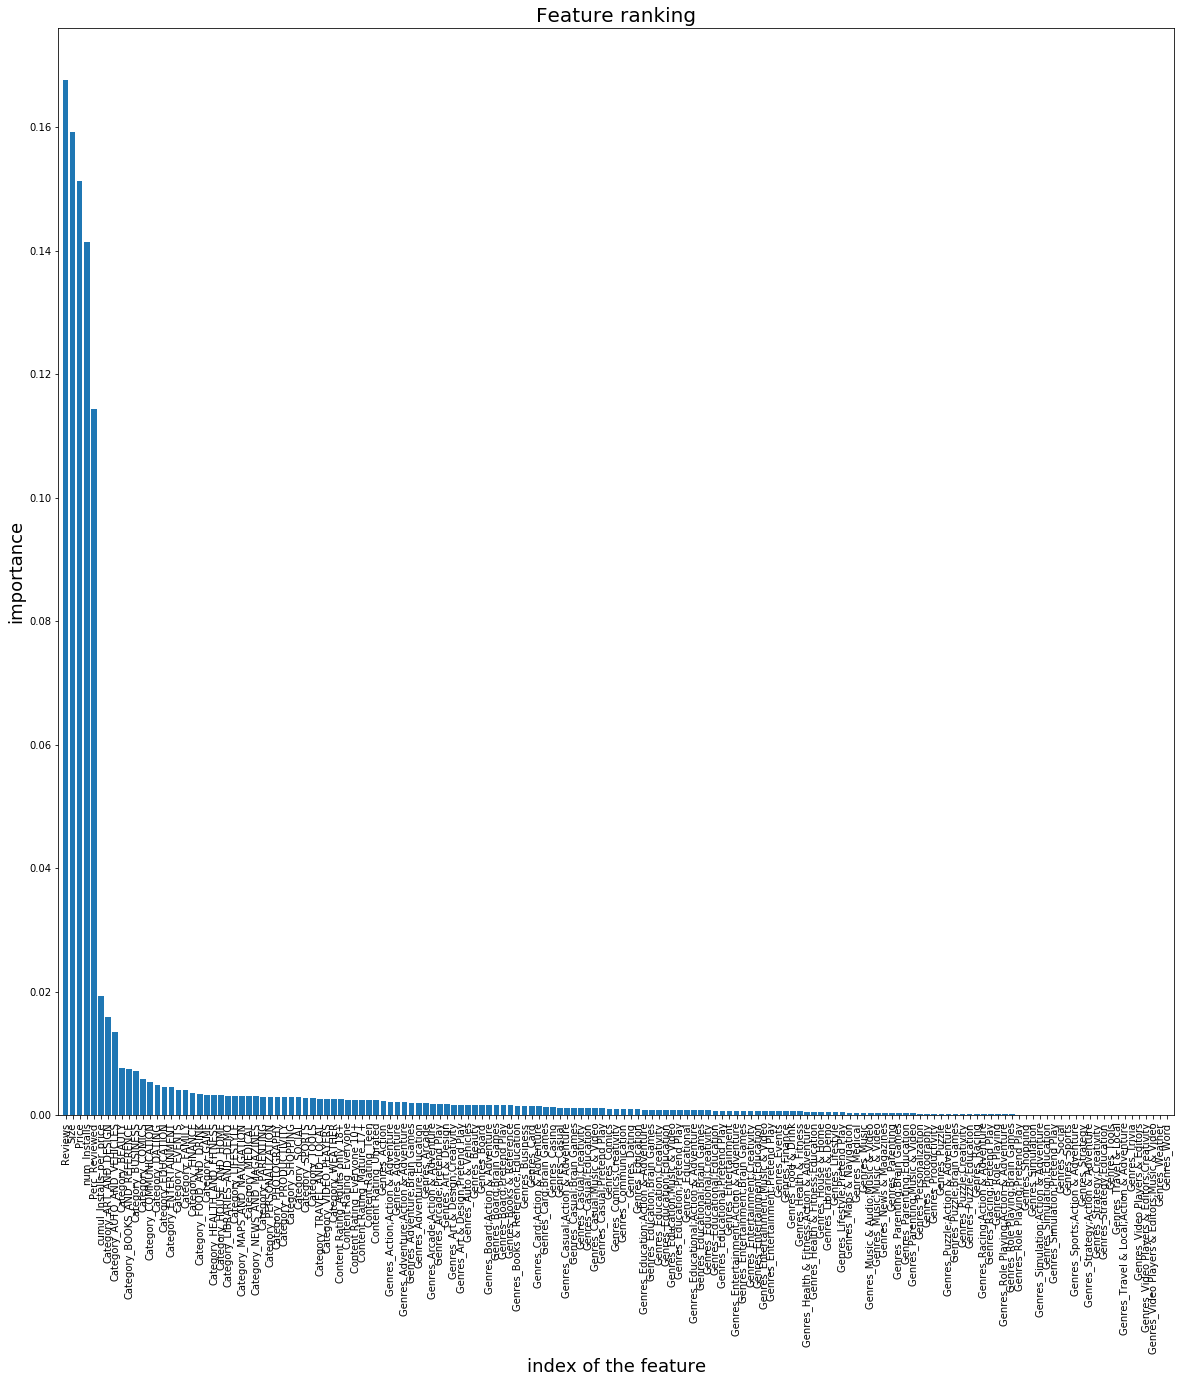

In [376]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = df_no_nan.drop(['Rating'], axis=1).columns
f, ax = plt.subplots(figsize=(20,20));
plt.title("Feature ranking", fontsize = 20);
plt.bar(range(X_train.shape[1]), importances[indices],align="center");
plt.xticks(range(X_train.shape[1]), indices);
plt.xlim([-1, X_train.shape[1]]);
plt.ylabel("importance", fontsize = 18);
plt.xlabel("index of the feature", fontsize = 18);
plt.xticks(range(X_train.shape[1]), feature_names, rotation=90);

The top 5 elements that help us predict with an accuracy of 11% are the number of reviews, the size of the app, the price, the number of intallations and the percentage reviewed, which makes sense:
- the more an application is liked, the more it will be installed and reviewed
- the size of the app might be linked to the graphics people tend to like more sofisticated designs.

Let's see if we can find anything with the name of the app

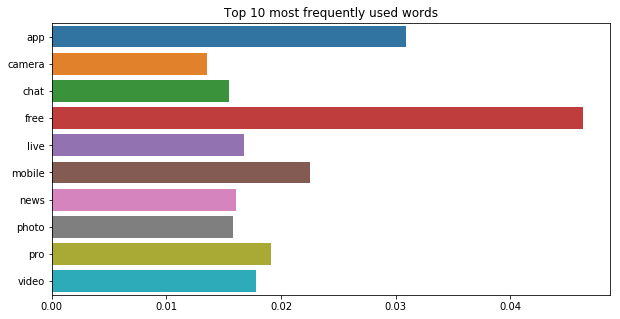

In [377]:
model = CountVectorizer(max_features=10, stop_words='english')
X = model.fit_transform(list(df['App']))
                             
plt.figure(figsize=(10,5))
plt.title('Top 10 most frequently used words')
sns.barplot(x=X.toarray().mean(axis=0), y=vectorizer.get_feature_names());

More than 4% of the apps in the Google play store have the word free in their name! The 2 other most important keywords are app and mobile.


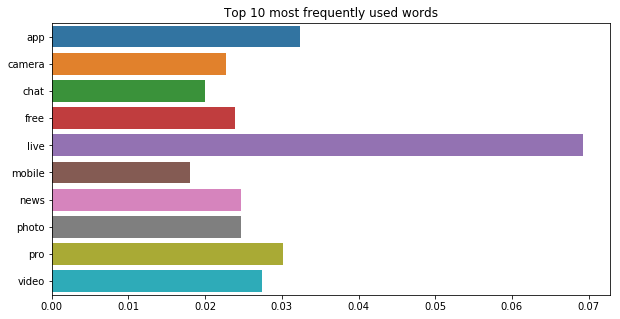

In [378]:
df['num_Installs'] = df['Installs'].apply({'10,000+':10000, '500,000+':500000, '5,000,000+':5000000,'50,000,000+':50000000, '100,000+':100000, '50,000+':50000, '1,000,000+':1000000, '10,000,000+':10000000, '5,000+':5000, '100,000,000+':100000000, '1,000,000,000+':1000000000, '1,000+':1000, '500,000,000+':500000000, '50+':50, '100+':100, '500+':500, '10+':10, '1+':1, '5+':5, '0+':0 }.get)
X = model.fit_transform(list(df[df['num_Installs']>=1000000]['App']))
                             
plt.figure(figsize=(10,5))
plt.title('Top 10 most frequently used words')
sns.barplot(x=X.toarray().mean(axis=0), y=vectorizer.get_feature_names());

But if we look at only at the apps that have been installed 1,000,000+ times, then the most important keyword is "live".